In [9]:
import json
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [4]:
# Function to load category names from COCO annotations
def load_custom_labels(file_path):
    """
    Extracts categories from a COCO-style annotation file.
    :param file_path: Path to the annotation JSON file.
    :return: Dictionary mapping category IDs to their names.
    """
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Extract category mapping
    categories = data.get("categories", [])
    category_dict = {category["id"]: category["name"] for category in categories}

    return category_dict

In [5]:
# Function to extract annotations from COCO file and match category names
def extract_annotations(file_path):
    """
    Extract annotations and match them with category names.
    :param file_path: Path to the annotation JSON file.
    :return: List of annotations with category names.
    """
    with open(file_path, 'r') as f:
        data = json.load(f)

    category_dict = load_custom_labels(file_path)
    annotations = data.get("annotations", [])

    annotation_details = []
    for annotation in annotations:
        category_name = category_dict.get(annotation["category_id"], "Unknown")
        annotation_details.append({
            "image_id": annotation["image_id"],
            "bbox": annotation["bbox"],
            "segmentation": annotation["segmentation"],
            "category_name": category_name,
            "area": annotation["area"],
            "iscrowd": annotation["iscrowd"]
        })

    return annotation_details

In [6]:
# Load the image for detection
def load_image(image_path):
    """
    Loads an image from the given path.
    :param image_path: Path to the image file.
    :return: The image as a PIL object.
    """
    return Image.open(image_path)

In [7]:
# Load Faster R-CNN model for detection
def load_model():
    """
    Load a pre-trained Faster R-CNN model.
    :return: The Faster R-CNN model.
    """
    model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
    model.eval()  # Set model to evaluation mode
    return model

In [8]:
# Visualize the image with bounding boxes and labels
def visualize_predictions(image, model, annotations, confidence_threshold=0.5):
    """
    Visualizes the image with predictions (bounding boxes and category names).
    :param image: The image to visualize.
    :param model: The object detection model (Faster R-CNN).
    :param annotations: The annotations with category names.
    :param confidence_threshold: The minimum confidence threshold for displaying predictions.
    """
    # Define the transformation - convert image to tensor
    transform = transforms.Compose([transforms.ToTensor()])

    # Apply the transformation to the image
    image_tensor = transform(image).unsqueeze(dim=0)  # Add batch dimension

    # Run the model on the image
    with torch.no_grad():
        predictions = model(image_tensor)

    # Convert tensor image back to numpy for visualization
    img = image_tensor.squeeze().cpu().numpy()  # Adjust dimensions as necessary
    img = img.transpose(1, 2, 0)  # Rearrange the dimensions from CxHxW to HxWxC for image display

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(12, 9))

    # Display the image
    ax.imshow(img)

    # Add bounding boxes and labels
    for box, label, score in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
        if score.item() > confidence_threshold:
            x1, y1, x2, y2 = box.detach().cpu().numpy()  # Make sure to detach and convert boxes as well

            # Adjust for potential off-by-one error
            label_name = annotations.get(label.item(), "Unknown")
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f'{label_name} {score.item():.2f}', color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')  # Turn off axes for better visualization
    plt.show()

In [10]:
# Main function to run the entire process
def main(annotation_file, image_path):
    """
    Main function to load annotations, model, and visualize the results.
    :param annotation_file: Path to the annotation JSON file.
    :param image_path: Path to the image file.
    """
    # Extract annotations from JSON
    annotations = extract_annotations(annotation_file)
    category_dict = load_custom_labels(annotation_file)

    # Load Faster R-CNN model
    model = load_model()

    # Load the test image
    image = load_image(image_path)

    # Visualize predictions
    visualize_predictions(image, model, category_dict, confidence_threshold=0.5)

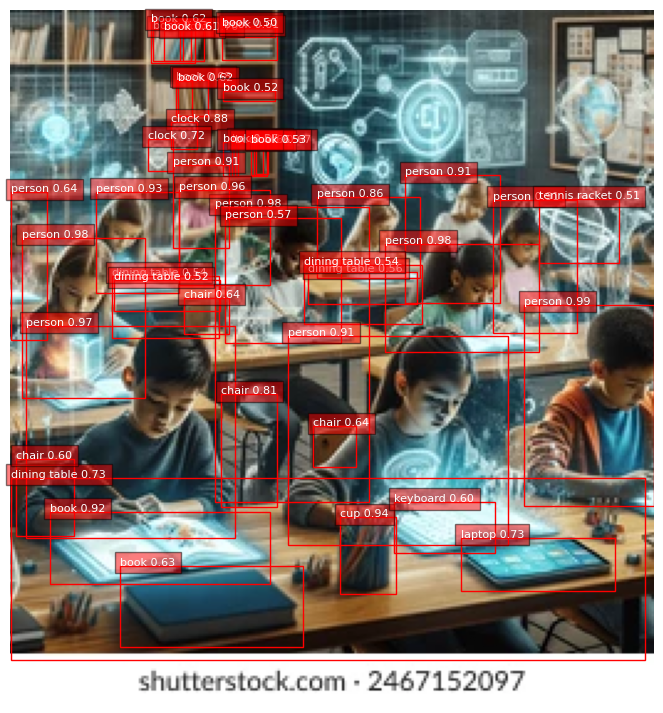

In [16]:
# Example usage
annotation_file = 'annotations.json'  # Replace with your annotation file path
image_path = 'students.webp'  # Replace with your image file path
main(annotation_file, image_path)